In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
import logging
import os
from typing import List, Tuple

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import market_data as mdata
import oms as oms

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-cd901ef5-2643-4bcc-8ffb-a93194a3413a.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.1.1' != container_version='1.1.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask2906_Research_vs_prod_reconciliation_20220923'
  hash='e1811a334'
  # Last commits:
    *   e1811a334 dan      Merge branch 'master' into CmTask2906_Research_vs_prod_reconciliation_20220923 (51 minutes ago) Tue Sep 27 11:29:07 2022  (HEAD -> CmTask2906_Research_vs_prod_reconciliation_20220923, origin/CmTask2906_Research_vs_prod_reconciliation_20220923)
    |\  
    | * b93a45373 Daniil Tikhomirov Cm task2890 get fills 

# Functions

In [4]:
def get_replayed_delay_in_mins(
    min_timestamp_from_file: pd.Timestamp,
    min_timestamp_from_prod: pd.Timestamp,
) -> int:
    """
    Compute replayed delay in minutes from minimal time in market data from
    file and prod system start time.
    """
    time_diff_in_secs = (
        min_timestamp_from_prod - min_timestamp_from_file
    ).total_seconds()
    replayed_delay_in_mins = int(time_diff_in_secs / 60)
    return replayed_delay_in_mins


def load_portfolio(
    portfolio_dir, start_timestamp, end_timestamp, freq
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load portfolio and related stats.
    """
    # Make sure the directory exists.
    hdbg.dassert_dir_exists(portfolio_dir)
    # Sanity-check timestamps.
    hdbg.dassert_isinstance(start_timestamp, pd.Timestamp)
    hdbg.dassert_isinstance(end_timestamp, pd.Timestamp)
    hdbg.dassert_lt(start_timestamp, end_timestamp)
    # Load the portfolio and stats dataframes.
    portfolio_df, portfolio_stats_df = oms.Portfolio.read_state(
        portfolio_dir,
    )
    # Sanity-check the dataframes.
    hpandas.dassert_time_indexed_df(
        portfolio_df, allow_empty=False, strictly_increasing=True
    )
    hpandas.dassert_time_indexed_df(
        portfolio_stats_df, allow_empty=False, strictly_increasing=True
    )
    # Sanity-check the date ranges of the dataframes against the start and end timestamps.
    first_timestamp = portfolio_df.index[0]
    hdbg.dassert_lte(first_timestamp.round(freq), start_timestamp)
    last_timestamp = portfolio_df.index[-1]
    hdbg.dassert_lte(end_timestamp, last_timestamp.round(freq))
    #
    portfolio_df = portfolio_df.loc[start_timestamp:end_timestamp]
    portfolio_stats_df = portfolio_stats_df.loc[start_timestamp:end_timestamp]
    #
    return portfolio_df, portfolio_stats_df


def compute_delay(df: pd.DataFrame, freq: str) -> pd.Series:
    """
    Compute forecast delays from bar timestamps.
    """
    bar_index = df.index.round(freq)
    delay_vals = df.index - bar_index
    delay = pd.Series(delay_vals, bar_index, name="delay")
    return delay


def check_for_missing_bars(df: pd.DataFrame, freq: str) -> None:
    """
    Check that no data bars are missed.
    """
    _LOG.info("Actual index=%s", df.index)
    hpandas.dassert_monotonic_index(df)
    actual_index = df.index.round(freq)
    min_ts = df.index.min()
    max_ts = df.index.max()
    expected_index = pd.date_range(start=min_ts, end=max_ts, freq=freq).round(
        freq
    )
    hdbg.dassert_set_eq(actual_index, expected_index)


# TODO(Grisha): @Dan Provide correct stats descriptions.
def print_stats(df: pd.DataFrame) -> None:
    """
    Print basic stats and sanity checks before doing heavy computations.

    Stats include:
    - minimal index timestamp
    - maximum index timestamp
    - fraction of assets with no difference in num shares
    - fraction of assets with empty num shares
    """
    _LOG.info("min timestamp=%s", df.index.min())
    _LOG.info("max timestamp=%s", df.index.max())
    n_zeros = sum(df["diff_num_shares"].sum(axis=1) == 0)
    _LOG.info(
        "fraction of diff_num_shares=0 is %s",
        hprint.perc(n_zeros, df["diff_num_shares"].shape[0]),
    )
    n_nans = df["diff_num_shares"].sum(axis=1).isna().sum()
    _LOG.info(
        "fraction of diff_num_shares=0 is %s",
        hprint.perc(n_nans, df["diff_num_shares"].shape[0]),
    )


# TODO(Paul): Clean up the system config handling.
def load_config_as_list(path: str) -> List[str]:
    """
    Load config as a list of string lines.
    """
    with open(path) as f:
        lines = f.readlines()
    _LOG.debug("Lines read=%d", len(lines))
    return lines


def diff_lines(list1: List[str], list2: List[str]) -> Tuple[List[str], List[str]]:
    """
    Get output lines that differ.
    """
    list1_only = list(set(list1) - set(list2))
    list2_only = list(set(list2) - set(list1))
    return list1_only, list2_only

# Set system parameters

In [5]:
aws_profile = "ck"
file_path = (
    "/shared_data/prod_reconciliation/20220923/simulation/test_data.csv.gz"
)
# file_path = "s3://cryptokaizen-data/unit_test/outcomes/Test_C1b_Time_ForecastSystem_with_DataFramePortfolio_ProdReconciliation/input/test_data.csv.gz"
column_remap = {
    "start_timestamp": "start_datetime",
    "end_timestamp": "end_datetime",
}
timestamp_db_column = "end_datetime"
datetime_columns = ["start_datetime", "end_datetime", "timestamp_db"]
market_data_df = mdata.load_market_data(
    file_path,
    # aws_profile=aws_profile,
    column_remap=column_remap,
    timestamp_db_column=timestamp_db_column,
    datetime_columns=datetime_columns,
)
market_data_df.head()

,index,end_datetime,asset_id,knowledge_timestamp,open,high,low,close,volume,end_download_timestamp,id,full_symbol,start_datetime,timestamp_db
0,0,2022-09-16 14:56:00+00:00,1030828978,2022-09-16 14:56:11.578348+00:00,0.6525,0.6526,0.6525,0.6526,10318.000,2022-09-16 14:56:10.575572+00:00,2983035,binance::GMT_USDT,2022-09-16 14:55:00+00:00,2022-09-16 14:56:00+00:00
1,1,2022-09-16 14:56:00+00:00,1464553467,2022-09-16 14:56:02.277583+00:00,1450.7800,1450.7900,1450.7800,1450.7800,1.918,2022-09-16 14:56:01.274741+00:00,2983029,binance::ETH_USDT,2022-09-16 14:55:00+00:00,2022-09-16 14:56:00+00:00
2,2,2022-09-16 14:56:00+00:00,1467591036,2022-09-16 14:56:03.805501+00:00,19688.4000,19688.4000,19687.2000,19687.3000,3.950,2022-09-16 14:56:02.802436+00:00,2983030,binance::BTC_USDT,2022-09-16 14:55:00+00:00,2022-09-16 14:56:00+00:00
3,3,2022-09-16 14:56:00+00:00,1528092593,2022-09-16 14:56:29.862926+00:00,0.2248,0.2250,0.2248,0.2248,29166.000,2022-09-16 14:56:28.860140+00:00,2983047,binance::BAKE_USDT,2022-09-16 14:55:00+00:00,2022-09-16 14:56:00+00:00
4,4,2022-09-16 14:56:00+00:00,1776791608,2022-09-16 14:56:22.230909+00:00,6.9880,6.9910,6.9870,6.9890,1759.600,2022-09-16 14:56:21.228125+00:00,2983042,binance::UNFI_USDT,2022-09-16 14:55:00+00:00,2022-09-16 14:56:00+00:00


In [6]:
min_market_data_end_time = (
    market_data_df["end_datetime"].min().tz_convert(tz="America/New_York")
)
min_market_data_end_time

Timestamp('2022-09-16 10:56:00-0400', tz='America/New_York')

In [7]:
max_market_data_end_time = (
    market_data_df["end_datetime"].max().tz_convert(tz="America/New_York")
)
max_market_data_end_time

Timestamp('2022-09-23 10:54:00-0400', tz='America/New_York')

In [8]:
date = "2022-09-23"
start_timestamp = pd.Timestamp(date + " 07:40:00", tz="America/New_York")
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = pd.Timestamp(date + " 10:00:00", tz="America/New_York")
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2022-09-23 07:40:00-04:00
INFO  end_timestamp=2022-09-23 10:00:00-04:00


In [9]:
replayed_delay_in_mins_or_timestamp = get_replayed_delay_in_mins(
    min_market_data_end_time,
    start_timestamp,
)
replayed_delay_in_mins_or_timestamp

9884

In [10]:
prod_dir = "/shared_data/prod_reconciliation/20220923/prod/system_log_dir_20220923_2hours"
sim_dir = "/shared_data/prod_reconciliation/20220923/simulation/system_log_dir"
prod_portfolio_dir = os.path.join(prod_dir, "process_forecasts/portfolio")
prod_forecast_dir = os.path.join(prod_dir, "process_forecasts")
sim_portfolio_dir = os.path.join(sim_dir, "process_forecasts/portfolio")
sim_forecast_dir = os.path.join(sim_dir, "process_forecasts")

In [11]:
dict_ = {
    "prod_forecast_dir": prod_forecast_dir,
    "sim_forecast_dir": sim_forecast_dir,
    "prod_portfolio_dir": prod_portfolio_dir,
    "sim_portfolio_dir": sim_portfolio_dir,
    "freq": "5T",
    "start_timestamp": start_timestamp,
    "end_timestamp": end_timestamp,
    "rename_col_map": {"index": "asset_id"},
}
#
config = cconfig.Config.from_dict(dict_)
display(config)

prod_forecast_dir: /shared_data/prod_reconciliation/20220923/prod/system_log_dir_20220923_2hours/process_forecasts
sim_forecast_dir: /shared_data/prod_reconciliation/20220923/simulation/system_log_dir/process_forecasts
prod_portfolio_dir: /shared_data/prod_reconciliation/20220923/prod/system_log_dir_20220923_2hours/process_forecasts/portfolio
sim_portfolio_dir: /shared_data/prod_reconciliation/20220923/simulation/system_log_dir/process_forecasts/portfolio
freq: 5T
start_timestamp: 2022-09-23 07:40:00-04:00
end_timestamp: 2022-09-23 10:00:00-04:00
rename_col_map:
  index: asset_id

# Forecasts

## Load prod and sim forecasts

In [12]:
prod_forecast_df = oms.ForecastProcessor.read_logged_target_positions(
    config["prod_forecast_dir"], rename_col_map=config["rename_col_map"].to_dict()
)
check_for_missing_bars(prod_forecast_df, config["freq"])
print_stats(prod_forecast_df)
hpandas.df_to_str(prod_forecast_df, log_level=logging.INFO)

Loading `target_positions` files...:   0%|          | 0/30 [00:00<?, ?it/s]

INFO  Actual index=DatetimeIndex(['2022-09-23 07:36:55.406008-04:00', '2022-09-23 07:42:17.550455-04:00', '2022-09-23 07:47:09.437714-04:00', '2022-09-23 07:52:07.257815-04:00', '2022-09-23 07:57:10.715085-04:00', '2022-09-23 08:02:00.557725-04:00', '2022-09-23 08:07:06.097187-04:00', '2022-09-23 08:12:05.923726-04:00', '2022-09-23 08:17:08.954777-04:00', '2022-09-23 08:22:09.895517-04:00', '2022-09-23 08:27:13.810952-04:00', '2022-09-23 08:32:15.635609-04:00', '2022-09-23 08:37:22.110867-04:00', '2022-09-23 08:42:16.927561-04:00', '2022-09-23 08:47:07.226062-04:00', '2022-09-23 08:52:16.423043-04:00', '2022-09-23 08:57:12.494127-04:00', '2022-09-23 09:02:12.595756-04:00', '2022-09-23 09:07:14.842336-04:00', '2022-09-23 09:12:17.062022-04:00', '2022-09-23 09:17:21.638096-04:00', '2022-09-23 09:22:16.066364-04:00', '2022-09-23 09:27:14.475413-04:00', '2022-09-23 09:32:16.816261-04:00', '2022-09-23 09:37:16.456016-04:00', '2022-09-23 09:42:11.617476-04:00', '2022-09-23 09:47:15.959700-04

curr_num_shares                                                                                                                                                                                                                                                                              price                                                                                                                                                                                                                                                                                 position                                                                                                                                                                                                                                                                         prediction                                                                                                                                                                                                                                                                         volatility                                                                                                                                                                                                                                                                             spread                                                                                                                                                                                                                                                                         target_position                                                                                                                                                                                                                                                                            target_notional_trade                                                                                                                                                                                                                                                                               diff_num_shares                                                                                                                                                                                                                                                                         diff_num_shares.before_apply_cc_limits                                                                                                                                                                                                                                                                               
asset_id                              1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 14675910

In [13]:
sim_forecast_df = oms.ForecastProcessor.read_logged_target_positions(
    config["sim_forecast_dir"], rename_col_map=config["rename_col_map"].to_dict()
)
check_for_missing_bars(sim_forecast_df, config["freq"])
print_stats(sim_forecast_df)
hpandas.df_to_str(sim_forecast_df, log_level=logging.INFO)

Loading `target_positions` files...:   0%|          | 0/30 [00:00<?, ?it/s]

INFO  Actual index=DatetimeIndex(['2022-09-23 07:35:11-04:00', '2022-09-23 07:40:11-04:00', '2022-09-23 07:45:11-04:00', '2022-09-23 07:50:11-04:00', '2022-09-23 07:55:11-04:00', '2022-09-23 08:00:11-04:00', '2022-09-23 08:05:11-04:00', '2022-09-23 08:10:11-04:00', '2022-09-23 08:15:11-04:00', '2022-09-23 08:20:11-04:00', '2022-09-23 08:25:11-04:00', '2022-09-23 08:30:11-04:00', '2022-09-23 08:35:11-04:00', '2022-09-23 08:40:11-04:00', '2022-09-23 08:45:11-04:00', '2022-09-23 08:50:11-04:00', '2022-09-23 08:55:11-04:00', '2022-09-23 09:00:11-04:00', '2022-09-23 09:05:11-04:00', '2022-09-23 09:10:11-04:00', '2022-09-23 09:15:11-04:00', '2022-09-23 09:20:11-04:00', '2022-09-23 09:25:11-04:00', '2022-09-23 09:30:11-04:00', '2022-09-23 09:35:11-04:00', '2022-09-23 09:40:11-04:00', '2022-09-23 09:45:11-04:00', '2022-09-23 09:50:11-04:00', '2022-09-23 09:55:11-04:00', '2022-09-23 10:00:11-04:00'], dtype='datetime64[ns, America/New_York]', name='wall_clock_timestamp', freq=None)
INFO  min tim

curr_num_shares                                                                                                                                                                                                                                                                              price                                                                                                                                                                                                                                                                                 position                                                                                                                                                                                                                                                                          prediction                                                                                                                                                                                                                                                                         volatility                                                                                                                                                                                                                                                                             spread                                                                                                                                                                                                                                                                         target_position                                                                                                                                                                                                                                                                          target_notional_trade                                                                                                                                                                                                                                                                              diff_num_shares                                                                                                                                                                                                                                                                         diff_num_shares.before_apply_cc_limits                                                                                                                                                                                                                                                                              
asset_id                       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 152809

## Compute forecast prod delay

In [14]:
prod_forecast_delay = compute_delay(prod_forecast_df, config["freq"])
hpandas.df_to_str(prod_forecast_delay, log_level=logging.INFO)

,delay
2022-09-23 07:35:00-04:00,0 days 00:01:55.406008
2022-09-23 07:40:00-04:00,0 days 00:02:17.550455
2022-09-23 07:45:00-04:00,0 days 00:02:09.437714
,...
2022-09-23 09:50:00-04:00,0 days 00:02:09.480684
2022-09-23 09:55:00-04:00,0 days 00:02:08.573503
2022-09-23 10:00:00-04:00,0 days 00:02:14.304181


<AxesSubplot:title={'center':'delay in seconds'}, xlabel='wall_clock_timestamp'>

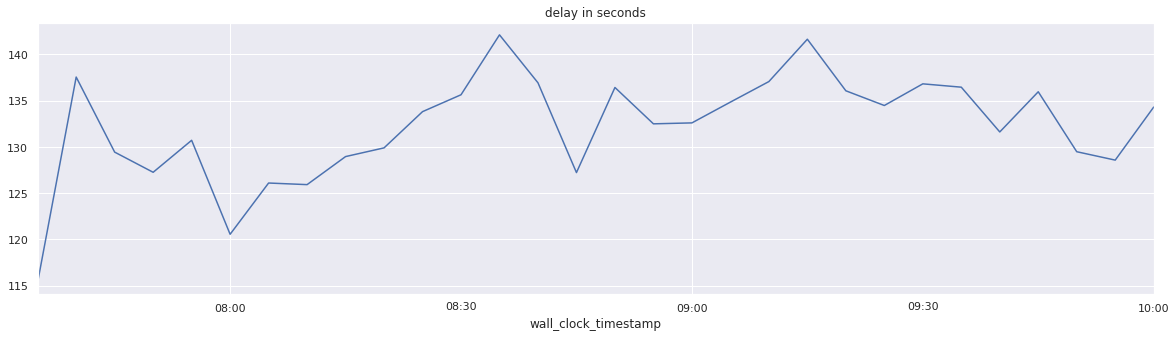

In [15]:
# Plot delay in seconds.
prod_forecast_delay.dt.total_seconds().plot(title="delay in seconds")

In [16]:
prod_forecast_df.index = prod_forecast_df.index.round(config["freq"])
sim_forecast_df.index = sim_forecast_df.index.round(config["freq"])
prod_forecast_df = prod_forecast_df.loc[start_timestamp:end_timestamp]
sim_forecast_df = sim_forecast_df.loc[start_timestamp:end_timestamp]

## Compare forecast dataframes

In [17]:
forecast_corrs = dtfmod.compute_correlations(prod_forecast_df, sim_forecast_df)
hpandas.df_to_str(forecast_corrs, precision=3, log_level=logging.INFO)

,curr_num_shares,price,position,prediction,volatility,spread,target_position,target_notional_trade,diff_num_shares,diff_num_shares.before_apply_cc_limits
1030828978,0.932,0.998,0.933,1.0,1.0,NaN,0.941,0.95,0.939,0.95
1464553467,0.999,0.997,0.999,1.0,1.0,NaN,0.927,0.977,0.963,0.976
1467591036,0.96,0.996,0.96,1.0,1.0,NaN,0.982,0.97,0.946,0.97
,...,...,...,...,...,...,...,...,...,...
8717633868,0.864,0.996,0.865,1.0,1.0,NaN,0.809,0.873,0.874,0.873
8968126878,0.832,0.995,0.832,1.0,1.0,NaN,0.834,0.809,0.81,0.809
9872743573,0.803,0.999,0.804,0.998,0.933,NaN,0.965,0.902,0.854,0.902


In [18]:
sort_col = "prediction"
hpandas.df_to_str(
    forecast_corrs.sort_values(sort_col, ascending=False),
    num_rows=10,
    precision=3,
    log_level=logging.INFO,
)

,curr_num_shares,price,position,prediction,volatility,spread,target_position,target_notional_trade,diff_num_shares,diff_num_shares.before_apply_cc_limits
1464553467,0.999,0.997,0.999,1.0,1.0,NaN,0.927,0.977,0.963,0.976
1030828978,0.932,0.998,0.933,1.0,1.0,NaN,0.941,0.95,0.939,0.95
1467591036,0.96,0.996,0.96,1.0,1.0,NaN,0.982,0.97,0.946,0.97
8717633868,0.864,0.996,0.865,1.0,1.0,NaN,0.809,0.873,0.874,0.873
4516629366,0.945,0.997,0.945,1.0,1.0,NaN,0.974,0.963,0.943,0.962
,...,...,...,...,...,...,...,...,...,...
2484635488,0.963,0.999,0.963,0.996,0.932,NaN,0.941,0.945,0.957,0.945
1891737434,0.872,0.997,0.871,0.995,0.972,NaN,0.932,0.934,0.911,0.934
2540896331,0.404,0.999,0.41,0.995,0.938,NaN,0.857,0.698,0.367,0.695
5115052901,0.888,0.999,0.888,0.994,0.852,NaN,0.9,0.902,0.909,0.902


# Orders

## Load prod and sim orders

In [19]:
prod_order_df = oms.ForecastProcessor.read_logged_orders(
    config["prod_forecast_dir"]
)
hpandas.df_to_str(prod_order_df, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/30 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz
0,2022-09-23 07:37:07.320897-04:00,6051632686,price@twap,2022-09-23 07:37:07.320897-04:00,2022-09-23 07:42:07.320897-04:00,0.0,5.0,America/New_York
1,2022-09-23 07:37:07.320897-04:00,8717633868,price@twap,2022-09-23 07:37:07.320897-04:00,2022-09-23 07:42:07.320897-04:00,0.0,2.0,America/New_York
2,2022-09-23 07:37:07.320897-04:00,2540896331,price@twap,2022-09-23 07:37:07.320897-04:00,2022-09-23 07:42:07.320897-04:00,0.0,-2.0,America/New_York
,...,...,...,...,...,...,...,...
1472,2022-09-23 10:02:26.143437-04:00,1776791608,price@twap,2022-09-23 10:02:26.143437-04:00,2022-09-23 10:07:26.143437-04:00,-11.7,16.8,America/New_York
1473,2022-09-23 10:02:26.143437-04:00,2384892553,price@twap,2022-09-23 10:02:26.143437-04:00,2022-09-23 10:07:26.143437-04:00,-6.3,-7.5,America/New_York
1474,2022-09-23 10:02:26.143437-04:00,5118394986,price@twap,2022-09-23 10:02:26.143437-04:00,2022-09-23 10:07:26.143437-04:00,5.4,-62.7,America/New_York


In [20]:
sim_order_df = oms.ForecastProcessor.read_logged_orders(
    config["sim_forecast_dir"]
)
hpandas.df_to_str(sim_order_df, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/30 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz
0,2022-09-23 07:35:11-04:00,6051632686,price@twap,2022-09-23 07:35:11-04:00,2022-09-23 07:40:11-04:00,0.0,5.0,America/New_York
1,2022-09-23 07:35:11-04:00,8717633868,price@twap,2022-09-23 07:35:11-04:00,2022-09-23 07:40:11-04:00,0.0,2.0,America/New_York
2,2022-09-23 07:35:11-04:00,2540896331,price@twap,2022-09-23 07:35:11-04:00,2022-09-23 07:40:11-04:00,0.0,-1.0,America/New_York
,...,...,...,...,...,...,...,...
747,2022-09-23 10:00:11-04:00,1776791608,price@twap,2022-09-23 10:00:11-04:00,2022-09-23 10:05:11-04:00,-3.6,8.8,America/New_York
748,2022-09-23 10:00:11-04:00,2384892553,price@twap,2022-09-23 10:00:11-04:00,2022-09-23 10:05:11-04:00,-13.4,26.7,America/New_York
749,2022-09-23 10:00:11-04:00,5118394986,price@twap,2022-09-23 10:00:11-04:00,2022-09-23 10:05:11-04:00,5.5,-62.7,America/New_York


# Portfolios

## Load prod portfolio

In [21]:
prod_portfolio_df, prod_portfolio_stats_df = load_portfolio(
    config["prod_portfolio_dir"],
    config["start_timestamp"],
    config["end_timestamp"],
    config["freq"],
)

Loading `holdings` files...:   0%|          | 0/30 [00:00<?, ?it/s]

Loading `holdings_marked_to_market` files...:   0%|          | 0/30 [00:00<?, ?it/s]

Loading `flows` files...:   0%|          | 0/30 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/30 [00:00<?, ?it/s]

In [22]:
hpandas.df_to_str(prod_portfolio_df, log_level=logging.INFO)

holdings                                                                                                                                                                                                                                                                                                             holdings_marked_to_market                                                                                                                                                                                                                                                                                                                   flows                                                                                                                                                                                                                                                                                                         pnl                                                                                                                                                                                                                                                                                                
                                  6051632686  8717633868  2540896331  1528092593  8968126878  1467591036  2476706208  5115052901  3065029174  1891737434  3401245610  1464553467  1966583502  1030828978  2601760471  2683705052  9872743573  2484635488  2099673105  4516629366  2237530510  2425308589  1776791608  2384892553  5118394986 -1                         1030828978  1464553467  1467591036  1528092593  1776791608  1891737434  1966583502  2099673105  2237530510  2384892553  2425308589  2476706208  2484635488  2540896331  2601760471  2683705052  3065029174  3401245610  4516629366  5115052901  5118394986  6051632686  8717633868  8968126878  9872743573 -1           6051632686  8717633868  2540896331  1528092593  8968126878  1467591036  2476706208  5115052901  3065029174  1891737434  3401245610  1464553467  1966583502  1030828978  2601760471  2683705052  9872743573  2484635488  2099673105  4516629366  2237530510  2425308589  1776791608  2384892553  5118394986  1030828978  1464553467  1467591036  1528092593  1776791608  1891737434  1966583502  2099673105  2237530510  2384892553  2425308589  2476706208  2484635488  2540896331  2601760471  2683705052  3065029174  3401245610  4516629366  5115052901  5118394986  6051632686  8717633868  8968126878  9872743573
2022-09-23 07:42:17.550455-04:00         5.0         2.0        -2.0       -82.0        0.26       0.006        14.1        34.0      -383.0        -6.7       -12.2       0.023       -95.0       -33.0        4.18        44.0         4.0      -354.0        15.0       -25.0        -1.0        46.0        -4.4        -9.9        61.5   565.75644                   -20.504    29.60859     113.372  -18.497833    -27.3218  -42.093867    -21.5232       23.84     -31.616   -38.89116   20.877867    12.46205   -51.10344     -25.272    29.92253   32.348067   -22.95702  -15.040567     -21.585    29.57388     29.9915   27.940833       34.66   70.978267   14.870667   565.75644      -27.97      -34.76       25.28     18.5484     -71.058   -113.4696    -12.5067     -29.648    23.00681     42.1899     15.0792   -29.65091      21.546     20.5161   -29.93716    -32.3928     -14.908     51.1176      -23.88       21.61       31.65     -20.907     27.3636     38.9367    -29.9997      0.0121    -0.04232     -0.0976    0.050567      0.0418    0.096033      0.0228       -0.04       0.034     0.04554   -0.029133    -0.04465     0.01416       0.008    -0.01463   -0.044733     0.04979    0.038633       0.025    -0.07412     -0.0082   -0.029167        -0.1   -0.079733   -0.037333
2022-09-23 07:47:09.437714-04:00        -1.0         0.0        -1.0        74.0        0.16      -0.005       -19.8       -55.0       118.0         9.3        24.4         0.0        37.0        47.0        0.74       -38.

In [23]:
hpandas.df_to_str(prod_portfolio_stats_df, log_level=logging.INFO)

,pnl,gross_volume,net_volume,gmv,nmv,cash,net_wealth,leverage
2022-09-23 07:42:17.550455-04:00,-0.203197,807.93218,134.24356,806.852137,134.040363,565.75644,699.796803,1.152981
2022-09-23 07:47:09.437714-04:00,-0.20176,1230.69239,-151.61857,624.643925,-17.779967,717.37501,699.595043,0.892865
2022-09-23 07:52:07.257815-04:00,-0.215707,1166.43558,-36.97242,743.978087,-54.968093,754.34743,699.379337,1.063769
,...,...,...,...,...,...,...,...
2022-09-23 09:47:15.959700-04:00,-0.415945,1267.66258,294.88542,772.810673,75.25444,619.893965,695.148405,1.11172
2022-09-23 09:52:09.480684-04:00,-0.458712,1014.10473,27.86935,731.240558,102.665078,592.024615,694.689693,1.052615
2022-09-23 09:57:08.573503-04:00,-1.045706,1254.88953,-381.83769,755.978585,-280.218318,973.862305,693.643987,1.089865


## Load sim portfolio

In [24]:
sim_portfolio_df, sim_portfolio_stats_df = load_portfolio(
    config["sim_portfolio_dir"],
    config["start_timestamp"],
    config["end_timestamp"],
    config["freq"],
)

Loading `holdings` files...:   0%|          | 0/30 [00:00<?, ?it/s]

Loading `holdings_marked_to_market` files...:   0%|          | 0/30 [00:00<?, ?it/s]

Loading `flows` files...:   0%|          | 0/30 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
hpandas.df_to_str(sim_portfolio_df, log_level=logging.INFO)

holdings                                                                                                                                                                                                                                                                                                             holdings_marked_to_market                                                                                                                                                                                                                                                                                                                   flows                                                                                                                                                                                                                                                                                                         pnl                                                                                                                                                                                                                                                                                                
                           6051632686  8717633868  2540896331  1528092593  8968126878  1467591036  2476706208  5115052901  3065029174  1891737434  3401245610  1464553467  1966583502  1030828978  2601760471  2683705052  9872743573  2484635488  2099673105  4516629366  2237530510  2425308589  1776791608  2384892553  5118394986 -1                         1030828978  1464553467  1467591036  1528092593  1776791608  1891737434  1966583502  2099673105  2237530510  2384892553  2425308589  2476706208  2484635488  2540896331  2601760471  2683705052  3065029174  3401245610  4516629366  5115052901  5118394986  6051632686  8717633868  8968126878  9872743573 -1           6051632686  8717633868  2540896331  1528092593  8968126878  1467591036  2476706208  5115052901  3065029174  1891737434  3401245610  1464553467  1966583502  1030828978  2601760471  2683705052  9872743573  2484635488  2099673105  4516629366  2237530510  2425308589  1776791608  2384892553  5118394986  1030828978  1464553467  1467591036  1528092593  1776791608  1891737434  1966583502  2099673105  2237530510  2384892553  2425308589  2476706208  2484635488  2540896331  2601760471  2683705052  3065029174  3401245610  4516629366  5115052901  5118394986  6051632686  8717633868  8968126878  9872743573
2022-09-23 07:40:11-04:00         5.0         2.0        -1.0       -81.0        0.26       0.006        13.9        56.0      -373.0        -6.6       -12.1       0.022       -90.0       -33.0        4.18        41.0         3.0      -317.0        15.0       -25.0        -1.0        45.0        -4.4        -9.7        61.5  533.180044                 -20.50455   28.330977    113.3754    -18.2763  -27.322533    -41.4799     -20.385     23.8475     -31.615  -38.104833      20.424   12.289917  -45.748383     -12.635    29.90372   30.145933  -22.350782   -14.92535  -21.586667   48.702267   29.988425   27.934167       34.66   70.984333      11.158  533.180044     -27.941     -34.664      12.636    18.27522    -70.9852   -113.3814    -12.2876   -48.70992    22.35762    41.47968    14.92414  -28.332172     20.3904    20.50752  -29.902884   -30.15058     -11.157    45.76212     -23.847     21.5885      31.616    -20.4273    27.32312    38.10548    -29.9997     0.00297   -0.001195      -0.006    -0.00108    0.000587    -0.00022      0.0054      0.0005       0.001    0.000647     -0.0033    0.002317    0.013737       0.001    0.000836   -0.004647    0.006838    -0.00121    0.001833   -0.007653   -0.011275   -0.006833      -0.004   -0.000867       0.001
2022-09-23 07:45:11-04:00        -1.0         0.0         1.0        79.0        0.16      -0.005       -20.0       -50.0       128.0         9.3        24.4         0.0        42.0        47.0        0.74       -38.0        11.0       4

In [26]:
hpandas.df_to_str(sim_portfolio_stats_df, log_level=logging.INFO)

,pnl,gross_volume,net_volume,gmv,nmv,cash,net_wealth,leverage
2022-09-23 07:40:11-04:00,-0.009616,796.751556,166.819956,796.678937,166.81034,533.180044,699.990384,1.138128
2022-09-23 07:45:11-04:00,-0.051489,1249.226048,-93.661184,650.176767,73.097667,626.841228,699.938895,0.928905
2022-09-23 07:50:11-04:00,0.108064,1234.171482,-83.076382,764.843685,-9.870652,709.91761,700.046958,1.092561
,...,...,...,...,...,...,...,...
2022-09-23 09:45:11-04:00,0.234391,1278.552044,205.633192,763.122583,71.813183,629.851272,701.664455,1.087589
2022-09-23 09:50:11-04:00,0.03055,1019.302498,-52.280518,799.189738,19.563215,682.13179,701.695005,1.138942
2022-09-23 09:55:11-04:00,-0.188436,1249.778194,-195.930386,726.99415,-176.555607,878.062176,701.506569,1.036333


## Compute prod portfolio delay

In [27]:
prod_portfolio_delay = compute_delay(prod_portfolio_df, config["freq"])
hpandas.df_to_str(prod_portfolio_delay, log_level=logging.INFO)

,delay
2022-09-23 07:40:00-04:00,0 days 00:02:17.550455
2022-09-23 07:45:00-04:00,0 days 00:02:09.437714
2022-09-23 07:50:00-04:00,0 days 00:02:07.257815
,...
2022-09-23 09:45:00-04:00,0 days 00:02:15.959700
2022-09-23 09:50:00-04:00,0 days 00:02:09.480684
2022-09-23 09:55:00-04:00,0 days 00:02:08.573503


<AxesSubplot:title={'center':'delay in seconds'}>

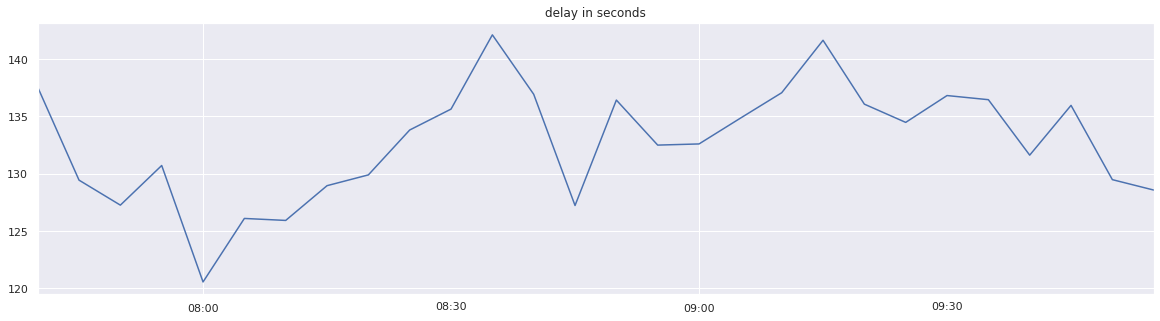

In [28]:
prod_portfolio_delay.dt.total_seconds().plot(title="delay in seconds")

In [29]:
_LOG.info("prod portfolio delay mean=%s", prod_portfolio_delay.mean())
_LOG.info("prod portfolio delay std=%s", prod_portfolio_delay.std())

INFO  prod portfolio delay mean=0 days 00:02:12.735780321
INFO  prod portfolio delay std=0 days 00:00:04.999745061


## Normalize bar times

In [30]:
dfs = [
    prod_portfolio_df,
    prod_portfolio_stats_df,
    sim_portfolio_df,
    sim_portfolio_stats_df,
]

In [31]:
for df in dfs:
    df.index = df.index.round(config["freq"])

## Compare portfolio stats

In [32]:
portfolio_stats_dfs = {
    "prod": prod_portfolio_stats_df,
    "sim": sim_portfolio_stats_df,
}
portfolio_stats_dfs = pd.concat(portfolio_stats_dfs, axis=1)

<AxesSubplot:>

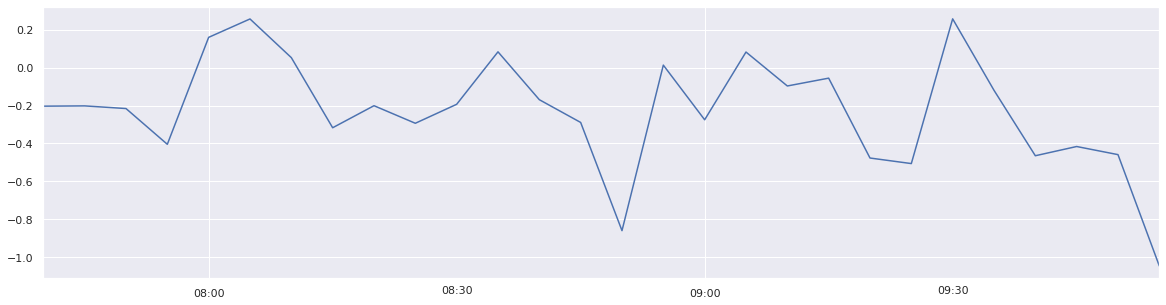

In [33]:
prod_portfolio_stats_df["pnl"].plot()

<AxesSubplot:>

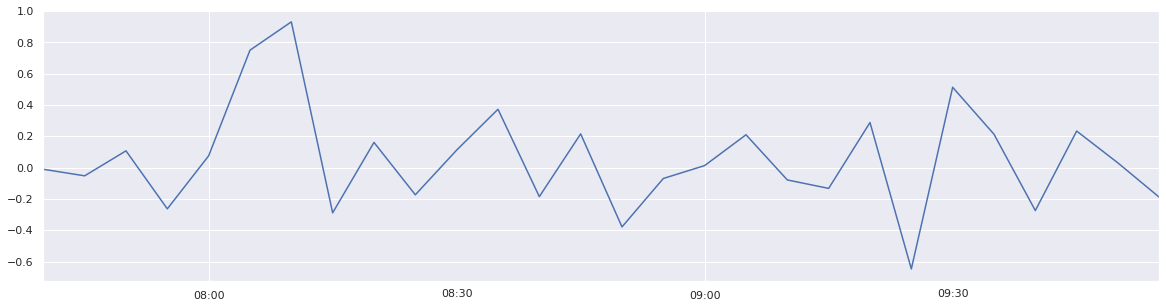

In [34]:
sim_portfolio_stats_df["pnl"].plot()

In [35]:
hpandas.df_to_str(portfolio_stats_dfs, log_level=logging.INFO)

prod                                                                                         sim                                                                                   
                                pnl gross_volume net_volume         gmv         nmv        cash  net_wealth  leverage       pnl gross_volume  net_volume         gmv         nmv        cash  net_wealth  leverage
2022-09-23 07:40:00-04:00 -0.203197    807.93218  134.24356  806.852137  134.040363   565.75644  699.796803  1.152981 -0.009616   796.751556  166.819956  796.678937   166.81034  533.180044  699.990384  1.138128
2022-09-23 07:45:00-04:00  -0.20176   1230.69239 -151.61857  624.643925  -17.779967   717.37501  699.595043  0.892865 -0.051489  1249.226048  -93.661184  650.176767   73.097667  626.841228  699.938895  0.928905
2022-09-23 07:50:00-04:00 -0.215707   1166.43558  -36.97242  743.978087  -54.968093   754.34743  699.379337  1.063769  0.108064  1234.171482  -83.076382  764.843685   -9.870652   709.91761  700.046958  1.092561
                                ...          ...        ...         ...         ...         ...         ...       ...       ...          ...         ...         ...         ...         ...         ...       ...
2022-09-23 09:45:00-04:00 -0.415945   1267.66258  294.88542  772.810673    75.25444  619.893965  695.148405   1.11172  0.234391  1278.552044  205.633192  763.122583   71.813183  629.851272  701.664455  1.087589
2022-09-23 09:50:00-04:00 -0.458712   1014.10473   27.86935  731.240558  102.665078  592.024615  694.689693  1.052615   0.03055  1019.302498  -52.280518  799.189738   19.563215   682.13179  701.695005  1.138942
2022-09-23 09:55:00-04:00 -1.045706   1254.88953 -381.83769  755.978585 -280.218318  973.862305  693.643987  1.089865 -0.188436  1249.778194 -195.930386   726.99415 -176.555607  878.062176  701.506569  1.036333

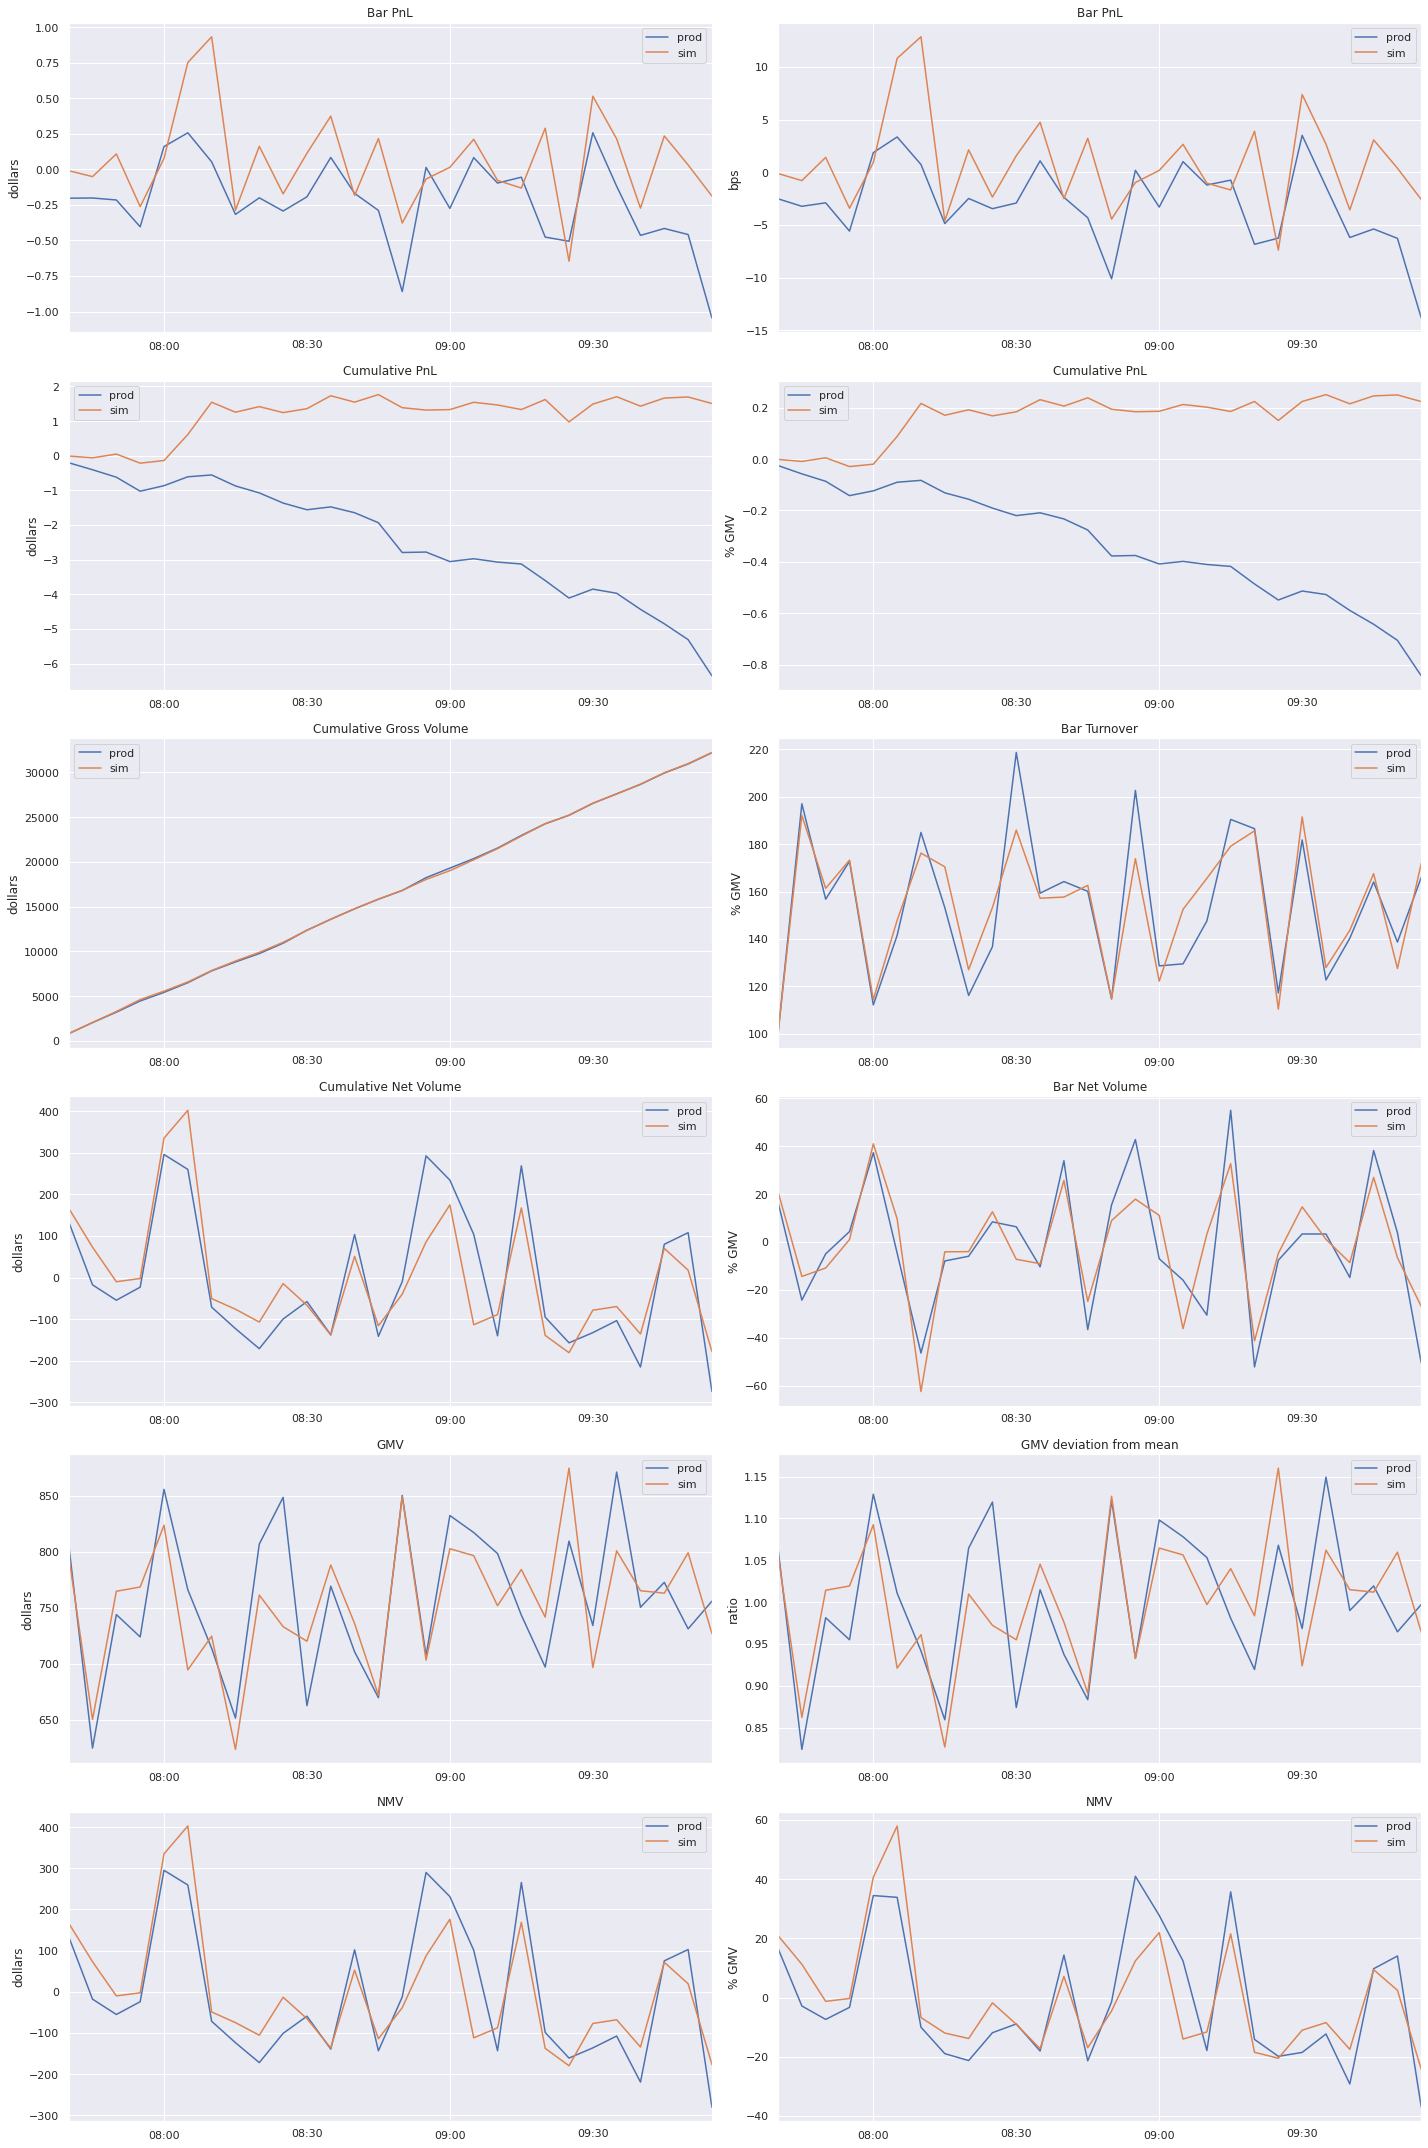

In [36]:
coplotti.plot_portfolio_stats(portfolio_stats_dfs)

In [37]:
portfolio_stats_corrs = dtfmod.compute_correlations(
    prod_portfolio_stats_df, sim_portfolio_stats_df
)
display(portfolio_stats_corrs.round(3))

,correlation
pnl,0.608
gross_volume,0.909
net_volume,0.863
gmv,0.750
nmv,0.865
cash,0.862
net_wealth,-0.573
leverage,0.753


In [38]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_dfs, config["freq"]
)
display(stats_sxs)

prod      sim
ratios     sharpe_ratio                  -246.04    52.31
           sharpe_ratio_standard_error     70.82    62.81
           sr.tval                         -4.01     0.85
           sr.pval                          0.00     0.40
           kratio                        -235.44    60.85
dollar     gmv_mean                       758.15   754.13
           gmv_stdev                       65.90    57.48
           annualized_mean_return      -23870.49  5658.04
           annualized_volatility           97.02   108.16
           max_drawdown                     6.15     0.79
           pnl_mean                        -0.23     0.05
           pnl_std                          0.30     0.33
           turnover_mean                 1150.21  1151.29
           turnover_stdev                 164.02   156.50
           market_bias_mean                -7.42    -0.92
           market_bias_stdev              165.07   145.35
percentage annualized_mean_return       -3170.46   841.05
           annualized_volatility           12.59    14.56
           max_drawdown                     0.82     0.09
           pnl_mean                        -0.03     0.01
           pnl_std                          0.04     0.04
           turnover_mean                  153.73   154.06
           turnover_stdev                  30.68    26.54
           market_bias_mean                -1.24    -0.15
           market_bias_stdev               21.58    19.32

## Compare portfolios at the instrument level

In [39]:
portfolio_corrs = dtfmod.compute_correlations(prod_portfolio_df, sim_portfolio_df)
hpandas.df_to_str(portfolio_corrs, precision=3, log_level=logging.INFO)

,holdings,holdings_marked_to_market,flows,pnl
6051632686,0.891,0.891,0.93,0.651
8717633868,0.879,0.88,0.937,0.553
2540896331,0.432,0.438,0.403,0.46
,...,...,...,...
2384892553,0.873,0.872,0.871,0.544
5118394986,0.983,0.984,0.993,0.877
-1,0.862,0.862,NaN,NaN


In [40]:
sort_col = "pnl"
hpandas.df_to_str(
    portfolio_corrs.sort_values(sort_col, ascending=False),
    num_rows=10,
    precision=3,
    log_level=logging.INFO,
)

,holdings,holdings_marked_to_market,flows,pnl
2425308589,0.927,0.928,0.935,0.884
5118394986,0.983,0.984,0.993,0.877
1528092593,0.875,0.876,0.923,0.789
2237530510,0.973,0.973,0.991,0.706
1467591036,0.967,0.966,0.968,0.692
,...,...,...,...
3401245610,0.676,0.678,0.649,0.31
1891737434,0.872,0.871,0.911,0.202
1966583502,0.86,0.861,0.858,0.081
2683705052,0.801,0.8,0.81,0.021


# System configs

In [41]:
prod_system_config_output = load_config_as_list(
    prod_dir + "/system_config.output.txt"
)
sim_system_config_output = load_config_as_list(
    sim_dir + "/system_config.output.txt"
)
prod_system_config_input = load_config_as_list(
    prod_dir + "/system_config.input.txt"
)
sim_system_config_input = load_config_as_list(
    sim_dir + "/system_config.input.txt"
)

In [42]:
prod_output_only, sim_output_only = diff_lines(
    prod_system_config_output, sim_system_config_output
)

In [43]:
# prod_output_only

In [44]:
# sim_output_only